In [1]:
#libaries
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [18]:
# read in the data: https://archive.ics.uci.edu/ml/datasets/Poker+Hand 
poker = pd.read_csv('poker-hand-testing.data.txt')
#set column names, attributes associated with columns as per data set guidelines
poker.columns = ['suit #1','rank #1', 'suit #2', 'rank#2', 'suit#3', 'rank#3', 'suit#4', 'rank#4', 'suit#5', 'rank#5', 'poker hand']
poker.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 11 columns):
suit #1       999999 non-null int64
rank #1       999999 non-null int64
suit #2       999999 non-null int64
rank#2        999999 non-null int64
suit#3        999999 non-null int64
rank#3        999999 non-null int64
suit#4        999999 non-null int64
rank#4        999999 non-null int64
suit#5        999999 non-null int64
rank#5        999999 non-null int64
poker hand    999999 non-null int64
dtypes: int64(11)
memory usage: 83.9 MB


0    501208
1    422498
2     47622
3     21121
4      3885
5      1996
6      1424
7       230
8        12
9         3
Name: poker hand, dtype: int64

In [19]:
poker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 11 columns):
suit #1       999999 non-null int64
rank #1       999999 non-null int64
suit #2       999999 non-null int64
rank#2        999999 non-null int64
suit#3        999999 non-null int64
rank#3        999999 non-null int64
suit#4        999999 non-null int64
rank#4        999999 non-null int64
suit#5        999999 non-null int64
rank#5        999999 non-null int64
poker hand    999999 non-null int64
dtypes: int64(11)
memory usage: 83.9 MB


In [20]:
poker['poker hand'].value_counts()

0    501208
1    422498
2     47622
3     21121
4      3885
5      1996
6      1424
7       230
8        12
9         3
Name: poker hand, dtype: int64

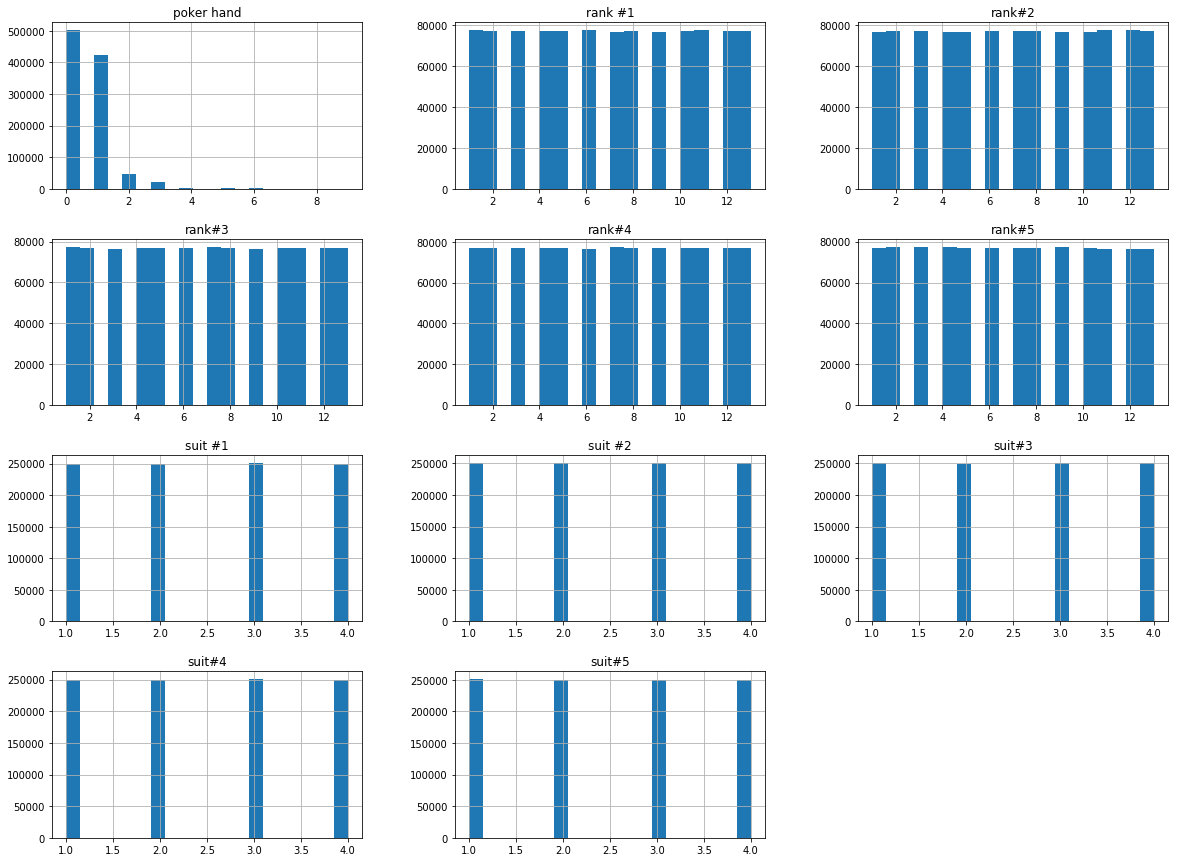

In [29]:
poker.hist(bins=(20), figsize=(20,15))
plt.show()